# Conclusiones

## Índice de Contenido

1. [Preparación del entorno y carga de datos](#1-preparación-del-entorno-y-carga-de-datos)
    - [Reproducción del modelo original](#reproducimos-el-modelo-usado-en-la-notebook-3-entrenando-un-primer-modelo)
2. Comparación de resultados
3. _Fairness_ y rendimientos
4. Reflexiones

## 1. Preparación del entorno y carga de datos

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from holisticai.pipeline import Pipeline
from holisticai.bias.mitigation import PrejudiceRemover
from holisticai.bias.metrics import classification_bias_metrics

from tp_final_fairness_ML.utils.models import ajustar_regresion_logistica, predecir_regresion_logistica

In [2]:
# Carga de datos
german_credit_csv_fqdn = os.path.join("..", "data", "processed", "df_genero_procesado.csv")
german_credit_df = pd.read_csv(german_credit_csv_fqdn)

In [3]:
# Modularizo el gráfico de la matriz de confusión
def plot_matriz_confusión(data, titulo):
    labels = ["Bajo riesgo (1)", "Alto riesgo (0)"]

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        data,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar=False
    )

    plt.text(0.25, 0.5, "TP", ha="center", va="center", color="green", fontsize=14, fontweight="bold")
    plt.text(1.25, 0.5, "FN", ha="center", va="center", color="red", fontsize=14, fontweight="bold")
    plt.text(0.25, 1.5, "FP", ha="center", va="center", color="red", fontsize=14, fontweight="bold")
    plt.text(1.25, 1.5, "TN", ha="center", va="center", color="green", fontsize=14, fontweight="bold")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.title(f"Matriz de confusión - {titulo}")
    plt.tight_layout()
    plt.show()

### Reproducimos el modelo usado en la notebook 3 "Entrenando un primer modelo"

In [4]:
# Separar atributos y target
X = german_credit_df.drop(columns=["target"], axis=1)
y = german_credit_df["target"]
idxs = X.index

# Train/Test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X.values,
    y.values,
    idxs,
    test_size=0.2,
    random_state=42
)

# Agregarmos una columna de ordenadas (intercepto)
X_train_intercept = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_intercept = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Ejecutamos el modelo
coefs = ajustar_regresion_logistica(X_train_intercept, y_train)
y_pred_test = predecir_regresion_logistica(X_test_intercept, coefs)

Entrenando modelo de regresión logística...
Predicciones completadas.


### Reproducimos el modelo mitigado usando _In-Processing_ _PrejudiceRemover_

In [5]:
X_test = pd.DataFrame(X_test, columns=X.columns, index=idx_test)
y_test = pd.Series(y_test, name='target', index=idx_test)
X_train = pd.DataFrame(X_train, columns=X.columns, index=idx_train)
y_train = pd.Series(y_train, name='target', index=idx_train)

# Defino el modelo (simple) y su mitigador
model = LogisticRegression(random_state=42, max_iter=1000)
mitigator = PrejudiceRemover(
    maxiter=100,
    fit_intercept=True,
    print_interval=1
).transform_estimator(model)

# Standardize data and fit model
scaler = StandardScaler()
group_a_train = X_train['genre_male'] == 1
group_b_train = X_train['genre_male'] == 0
group_a_test = X_test['genre_male'] == 1
group_b_test = X_test['genre_male'] == 0
X_train = scaler.fit_transform(X_train)
mitigator.fit(X_train, y_train, group_a_train, group_b_train)

# Standardize data and predict
X_test = scaler.transform(X_test)
y_mitigated_pred_test = mitigator.predict(X_test, group_a_test, group_b_test)

In [17]:
# Índices de los grupos
idx_group_0 = y_test.index[y_test.index.isin(idx_test) & (group_a_test == False)]
idx_group_1 = y_test.index[y_test.index.isin(idx_test) & (group_a_test == True)]
y_test_female = y_test.loc[idx_group_0]
y_pred_test_female = y_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_0]]
y_test_male = y_test.loc[idx_group_1]
y_pred_test_male = y_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_1]]
y_mitigated_pred_test_female = y_mitigated_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_0]]
y_mitigated_pred_test_male = y_mitigated_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_1]]

# Para el modelo sin mitigación
cm_group_0 = confusion_matrix(
    y_test_female,
    y_pred_test_female,
    labels=[1, 0]
)
cm_group_1 = confusion_matrix(
    y_test_male,
    y_pred_test_male,
    labels=[1, 0]
)

# Para el modelo mitigado
cm_mitigated_group_0 = confusion_matrix(
    y_test_female,
    y_mitigated_pred_test_female,
    labels=[1, 0]
)
cm_mitigated_group_1 = confusion_matrix(
    y_test_male,
    y_mitigated_pred_test_male,
    labels=[1, 0]
)

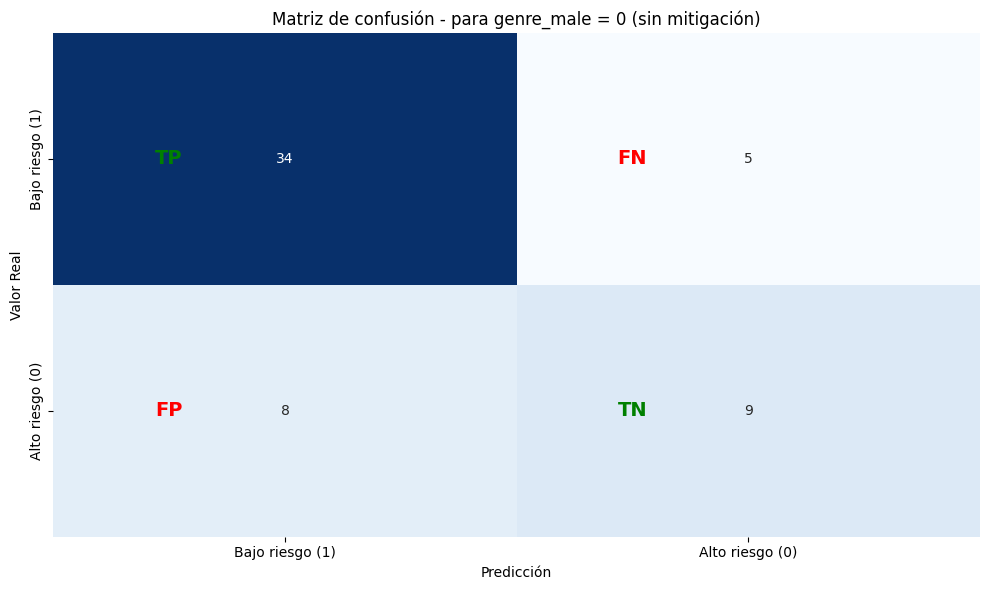

              precision    recall  f1-score   support

           0       0.64      0.53      0.58        17
           1       0.81      0.87      0.84        39

    accuracy                           0.77        56
   macro avg       0.73      0.70      0.71        56
weighted avg       0.76      0.77      0.76        56



In [15]:
plot_matriz_confusión(cm_group_0, "para genre_male = 0 (sin mitigación)")
print(classification_report(y_test_female, y_pred_test_female))

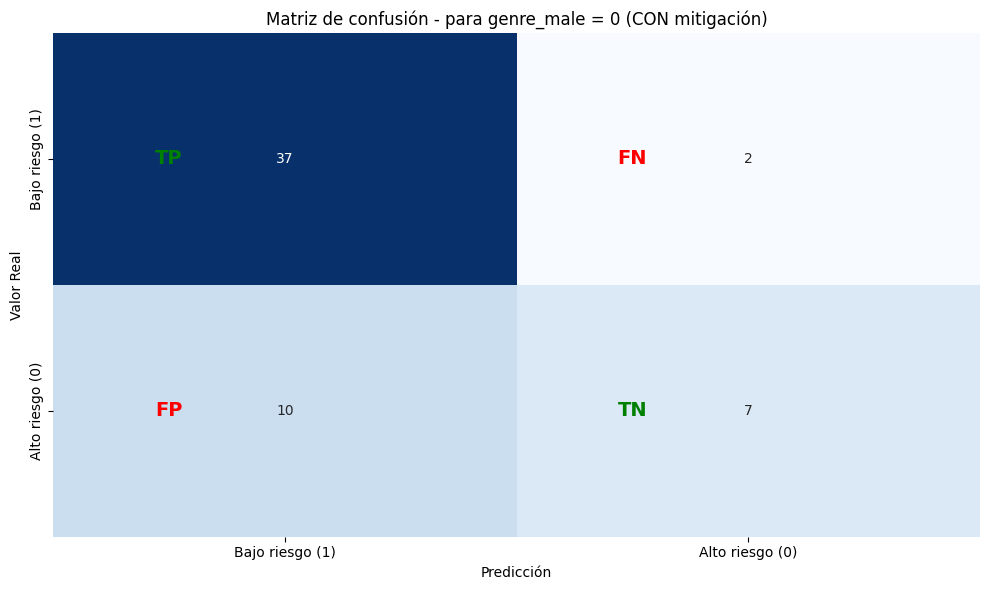

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        17
           1       0.79      0.95      0.86        39

    accuracy                           0.79        56
   macro avg       0.78      0.68      0.70        56
weighted avg       0.78      0.79      0.76        56



In [18]:
plot_matriz_confusión(cm_mitigated_group_0, "para genre_male = 0 (CON mitigación)")
print(classification_report(y_test_female, y_mitigated_pred_test_female))

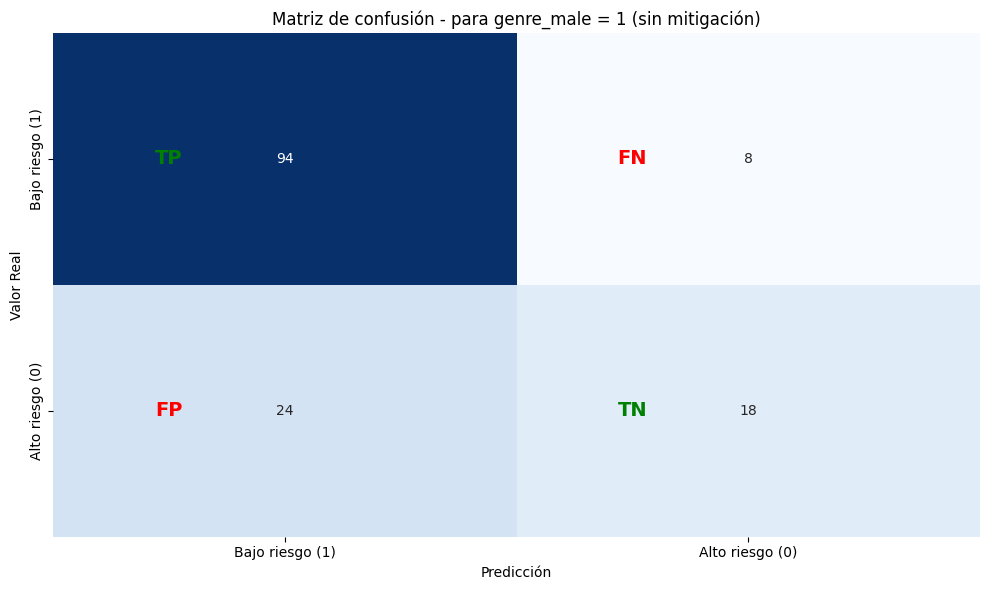

              precision    recall  f1-score   support

           0       0.69      0.43      0.53        42
           1       0.80      0.92      0.85       102

    accuracy                           0.78       144
   macro avg       0.74      0.68      0.69       144
weighted avg       0.77      0.78      0.76       144



In [16]:
plot_matriz_confusión(cm_group_1, "para genre_male = 1 (sin mitigación)")
print(classification_report(y_test_male, y_pred_test_male))

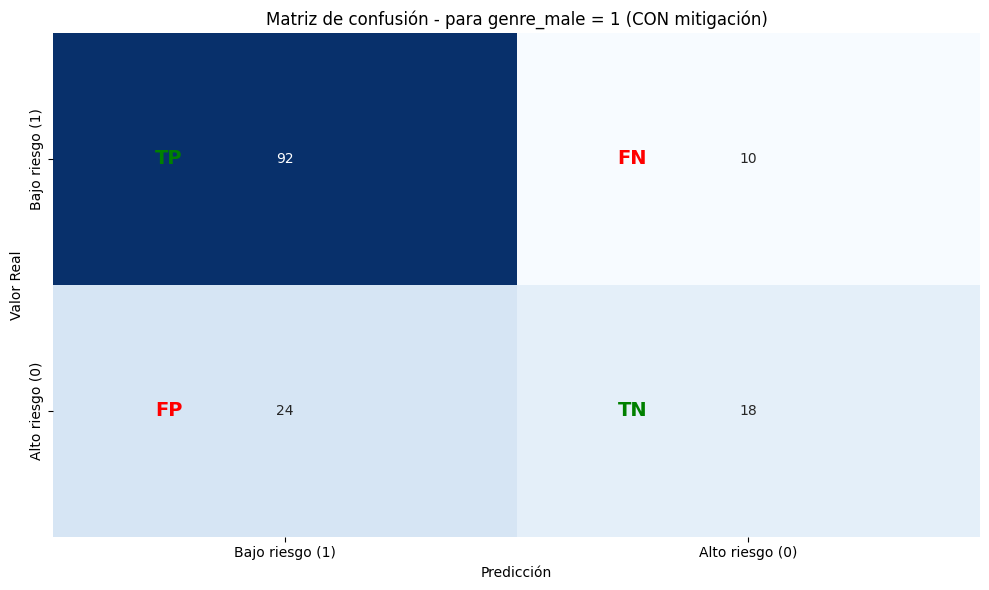

              precision    recall  f1-score   support

           0       0.64      0.43      0.51        42
           1       0.79      0.90      0.84       102

    accuracy                           0.76       144
   macro avg       0.72      0.67      0.68       144
weighted avg       0.75      0.76      0.75       144



In [19]:
plot_matriz_confusión(cm_mitigated_group_1, "para genre_male = 1 (CON mitigación)")
print(classification_report(y_test_male, y_mitigated_pred_test_male))

In [9]:
# Modelo normal
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.46      0.55        59
           1       0.80      0.91      0.85       141

    accuracy                           0.78       200
   macro avg       0.74      0.68      0.70       200
weighted avg       0.76      0.78      0.76       200



In [10]:
# Modelo mitigado
print(classification_report(y_test, y_mitigated_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.42      0.52        59
           1       0.79      0.91      0.85       141

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.76      0.77      0.75       200



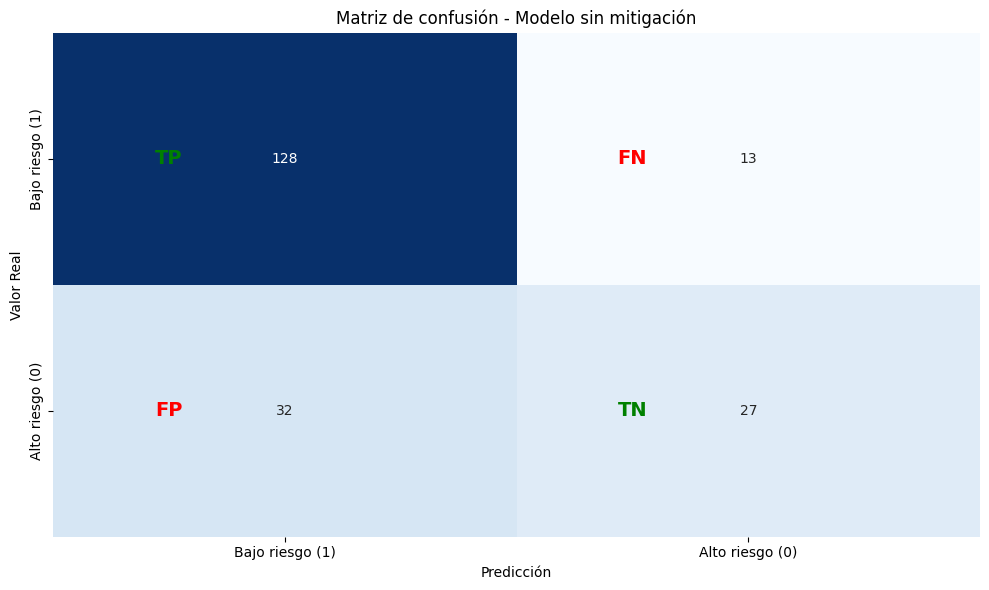

In [11]:
matrix = confusion_matrix(y_test, y_pred_test, labels=[1, 0])
plot_matriz_confusión(matrix, "Modelo sin mitigación")

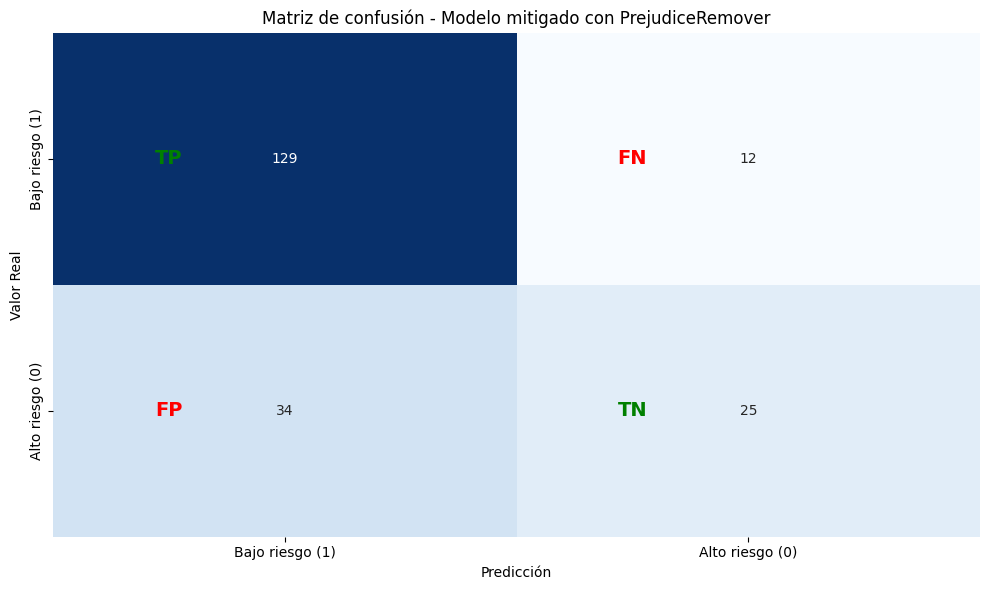

In [12]:
matrix = confusion_matrix(y_test, y_mitigated_pred_test, labels=[1, 0])
plot_matriz_confusión(matrix, "Modelo mitigado con PrejudiceRemover")

El modelo construido especialmente para clasificar el dataset German Credit y los atributos elegidos han performado igual o mejor que PrejudiceRemover. Se obtienen resultados y métricas muy parecidas.

## [BORRADOR PARA CHEQUEAR - SACAR PARA VERSION FINAL] Extra: modelo LogisticRegressor de `scikit-learn`

In [20]:
# Creamos y entrenamos un modelo LogisticRegression simple (sin mitigación)
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Predicciones sobre el set de test
y_logreg_pred_test = logreg.predict(X_test)

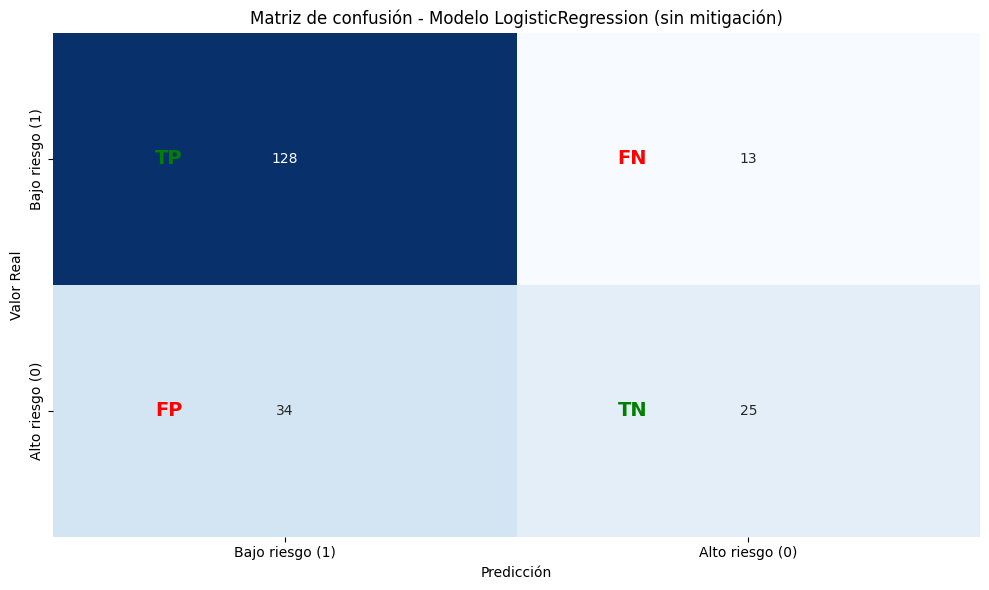

              precision    recall  f1-score   support

           0       0.66      0.42      0.52        59
           1       0.79      0.91      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200



In [21]:
matrix_logreg = confusion_matrix(y_test, y_logreg_pred_test, labels=[1, 0])
plot_matriz_confusión(matrix_logreg, "Modelo LogisticRegression (sin mitigación)")
print(classification_report(y_test, y_logreg_pred_test))

In [25]:
y_logreg_pred_test_female = y_logreg_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_0]]
y_logreg_pred_test_male = y_logreg_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_1]]

# Para el modelo sin mitigación
cm_logreg_group_0 = confusion_matrix(
    y_test_female,
    y_logreg_pred_test_female,
    labels=[1, 0]
)
cm_logreg_group_1 = confusion_matrix(
    y_test_male,
    y_logreg_pred_test_male,
    labels=[1, 0]
)

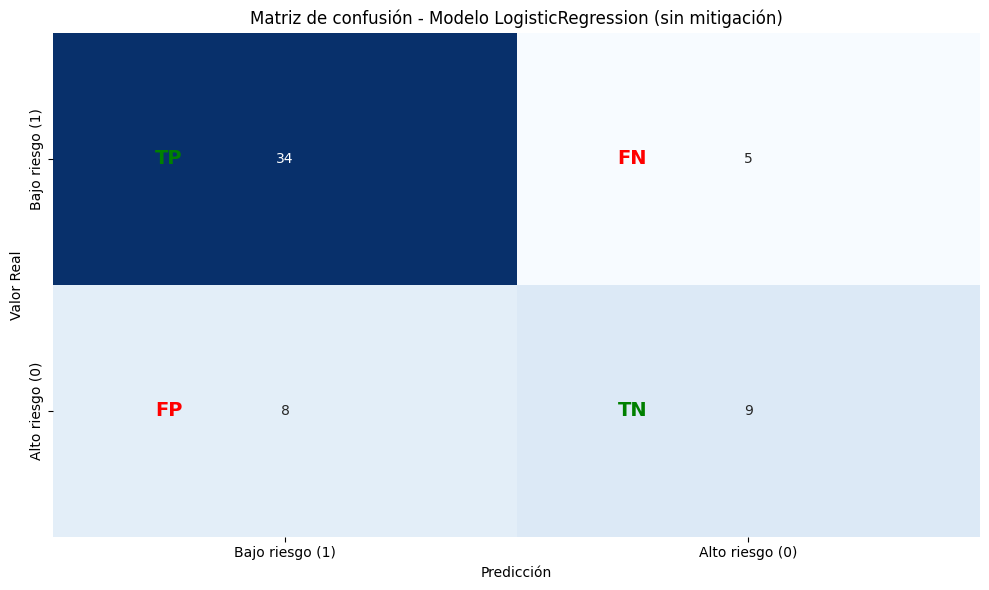

              precision    recall  f1-score   support

           0       0.64      0.53      0.58        17
           1       0.81      0.87      0.84        39

    accuracy                           0.77        56
   macro avg       0.73      0.70      0.71        56
weighted avg       0.76      0.77      0.76        56



In [27]:
plot_matriz_confusión(cm_logreg_group_0, "Modelo LogisticRegression (sin mitigación)")
print(classification_report(y_test_female, y_logreg_pred_test_female))

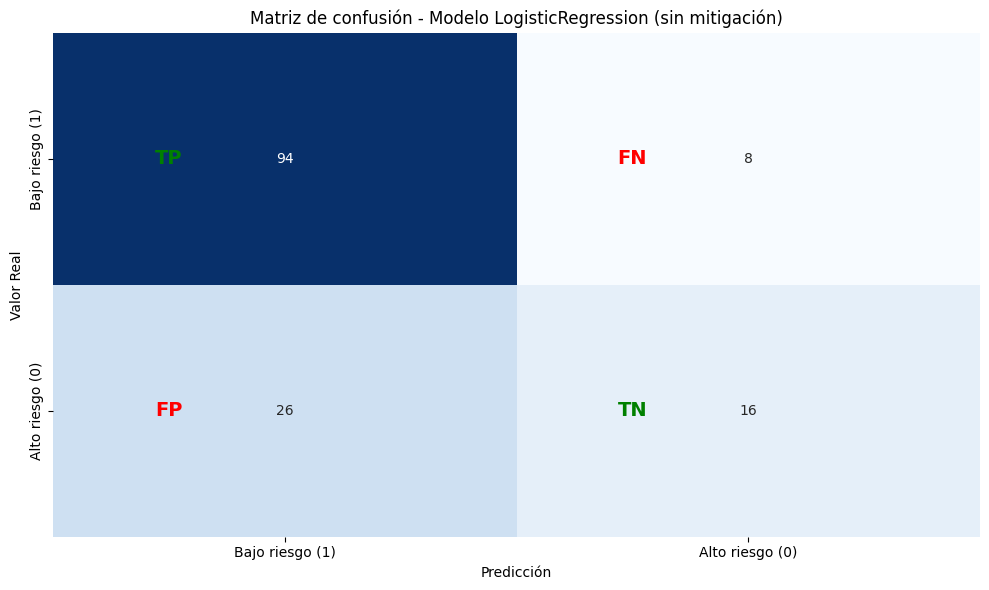

              precision    recall  f1-score   support

           0       0.67      0.38      0.48        42
           1       0.78      0.92      0.85       102

    accuracy                           0.76       144
   macro avg       0.72      0.65      0.67       144
weighted avg       0.75      0.76      0.74       144



In [28]:
plot_matriz_confusión(cm_logreg_group_1, "Modelo LogisticRegression (sin mitigación)")
print(classification_report(y_test_male, y_logreg_pred_test_male))